In [82]:
import numpy as np
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

__1.__  К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [68]:
def e_metrics(x1, x2):
    distance = np.sum(np.square(x1 - x2))
    return np.sqrt(distance)

In [69]:
def knn(x_train, y_train, x_test, k, weights=False, q=0.5):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответ на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов 
        for d in sorted(test_distances)[0:k]:

            if weights==True:
              # расчитаем вес объекта  
              weight = (q) ** d[0]
              classes[d[1]] += weight
            
            else:
              # подсчитаем частоту появления разных классов
              classes[d[1]] += 1


        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

(350, 4) (150, 4)


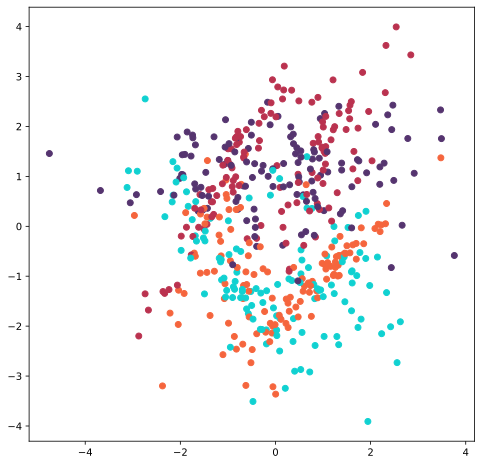

In [86]:
X, y = make_classification(n_samples=500, n_features=4, n_informative=3,
                           n_redundant=1, n_classes=4, random_state=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=24,
                                                    stratify=y)

cmap = ListedColormap(['#F5653D', '#10D1D1', '#55346F', '#BA324F'])
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

print(X_train.shape, X_test.shape)

In [71]:
def confus_matrix(y_true, y_pred):
    TP = len([e for e in map(lambda x,y: (y==1) & (x == y), y_true, y_pred) if e])
    FP = len([e for e in map(lambda x,y: (y==1) & (x != y), y_true, y_pred) if e])
    TN = len([e for e in map(lambda x,y: (y==0) & (x == y), y_true, y_pred) if e])
    FN = len([e for e in map(lambda x,y: (y==0) & (x != y), y_true, y_pred) if e])
    matrix = np.array([[TP, FP], [FN, TN]])
    return matrix

def fscore(y_true, y_pred, beta=1):
    matrix = confus_matrix(y_true, y_pred)
    TP = matrix[0, 0]; FP = matrix[0, 1]; FN = matrix[1, 0]; TN = matrix[1, 1]
    f = ((1 + beta**2) * TP) / (((1 + beta**2) * TP) + beta**2 * FN + FP)
    return  f

In [80]:
y_pred_w = knn(X_train, Y_train, X_test, 5, weights=True)
y_pred = knn(X_train, Y_train, X_test, 5)

print(f'f-score для KNN при k=5: {fscore(Y_test, y_pred):.4f}', 
      f'f-score для взвешенного KNN при k=5: {fscore(Y_test, y_pred_w):.4f}', sep='\n')

f-score для KNN при k=5: 0.8095
f-score для взвешенного KNN при k=5: 0.8140


__2*.__ Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [161]:
def mean_squared_cluster_cohesion(centroids, clusters):
  '''
  Функция подсчета среднего квадратичного внутрикластерного расстояния. 

  centroids: центроиды кластеров
  clusters: словарь из номера кластера с соответствующими ему наблюдениями
  '''
  n_clusters = len(centroids)
  distances = 0

  for cl in range(n_clusters):
    distances += np.sum(np.array([(np.linalg.norm(clusters[cl][i] - centroids[cl], ord=2))**2 for i in range(len(clusters[cl]))]))
  
  return distances/n_clusters

In [162]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

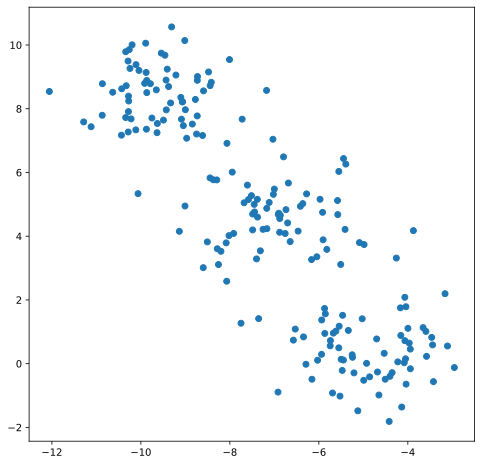

In [176]:
X, y = make_blobs(n_samples=200, random_state=12)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1]);

In [177]:
def visualize(centroids, clusters):
    colors = ['#F5653D', '#10D1D1', '#55346F', '#BA324F']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for cluster_item in clusters:
        for x in clusters[cluster_item]:
            plt.scatter(x[0], x[1], color=colors[cluster_item])
            
    plt.show()

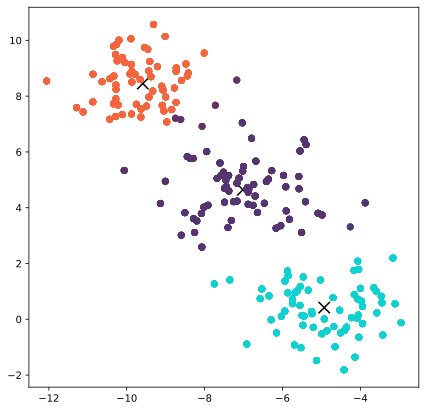

Mean squared cluster cohesion: 1268.9693


In [179]:
centroid, cluster = kmeans(X, 3, 10, 1e-5)
visualize(centroid, cluster)
print(f'Mean squared cluster cohesion: {mean_squared_cluster_cohesion(centroid, cluster):.4f}')

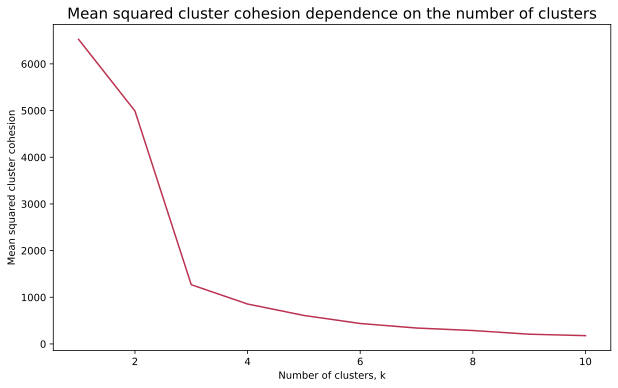

In [180]:
metrics = []
N = 10

for k in range(1, N+1):
  centers, clusters = kmeans(X, k, 10, 1e-5)
  mscc = mean_squared_cluster_cohesion(centers, clusters)
  metrics.append(mscc)

plt.figure(figsize=(10, 6))
plt.plot([i for i in range(1, N+1)], metrics, c='#BA324F')
plt.title('Mean squared cluster cohesion dependence on the number of clusters', size=15)
plt.xlabel('Number of clusters, k')
plt.ylabel('Mean squared cluster cohesion')
plt.show()

__3*.__ Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).